# **Importación de las librerías**

In [ ]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.model_selection import (
    cross_validate,
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform
from sklearn.metrics import ConfusionMatrixDisplay
import json


# Funciones auxiliares para la representación de los resultados

## **Función para mostrar una matriz de confusión**

In [ ]:
def mostrar_matriz_confusion(y_true, y_pred, modelo, title=None):
    """
    Muestra la matriz de confusión para un conjunto de etiquetas reales y predichas.

    Args:
        y_true (array-like): Etiquetas reales (verdaderas) del conjunto de datos.
        y_pred (array-like): Etiquetas predichas por el modelo.
        modelo (str): Nombre del modelo.
        title (str, optional): Título personalizado para el gráfico. Si no se proporciona,
                               se generará uno automáticamente con el nombre del modelo.

    Returns:
        None
    """
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Saludable", "Quiebra"])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(title if title else f"Matriz de Confusión - {modelo.upper()}")
    plt.grid(False)
    plt.show()


## **Función para representar la curva ROC**

In [ ]:
def graficar_curvas_roc_comparativas(validaciones_dict, title="Curvas ROC comparativas por modelo"):
    """
    Genera una gráfica comparativa de curvas ROC para los modelos dados.

    Args:
        validaciones_dict (dict): Diccionario con los resultados de test de cada modelo.
                                  Cada valor debe tener un DataFrame con columnas 'Real' y 'Probabilidad_Quiebra'.
        title (str, optional): Título del gráfico. Por defecto es 'Curvas ROC comparativas por modelo'.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    for modelo, datos in validaciones_dict.items():
        y_true = datos["resultados"]["Real"].values
        y_scores = datos["resultados"]["Probabilidad_Quiebra"].values
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{modelo.upper()} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## **Función para calcular las métricas de validación**

In [ ]:
def calcular_metricas_validacion(y_true, y_pred, y_prob):
    """
    Calcula un conjunto de métricas de evaluación para un modelo de clasificación binaria.

    Calcula accuracy, F1-score, precisión, recall, especificidad y AUC-ROC a partir de
    las etiquetas verdaderas, las predicciones y las probabilidades predichas.

    Args:
        y_true (array-like): Etiquetas verdaderas del conjunto de datos.
        y_pred (array-like): Etiquetas predichas por el modelo (0 o 1).
        y_prob (array-like or None): Probabilidades predichas para la clase positiva.
                                    Si es None, la métrica AUC-ROC no se calcula.

    Returns:
        dict: Diccionario con las métricas calculadas:
            - "accuracy": Exactitud.
            - "f1_score": Puntuación F1.
            - "precision": Precisión.
            - "recall": Sensibilidad o recall.
            - "specificity": Especificidad.
            - "roc_auc": Área bajo la curva ROC (o None si y_prob es None).
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "specificity": tn / (tn + fp),
        "roc_auc": roc_auc_score(y_true, y_prob) if y_prob is not None else None
}

# **Modelos Machine Learning**

## **Clase para creación de los modelos**

In [ ]:
class FinancialDistressPredictor:
    """
    Clase para la predicción del estrés financiero (probabilidad de quiebra) en empresas mediante modelos de machine learning.

    Esta clase permite:
    - Cargar y preprocesar datos financieros desde un archivo Excel.
    - Aplicar técnicas de limpieza, escalado y balanceo de clases (SMOTE).
    - Entrenar y validar modelos de clasificación como Regresión Logística, SVM o Random Forest.
    - Realizar búsqueda de hiperparámetros con validación cruzada.
    - Almacenar y reportar métricas de evaluación como accuracy, F1, precision, recall, especificidad y AUC.
    - Validar el rendimiento del modelo entrenado en un conjunto de datos externo (otro año o conjunto de empresas).

    Atributos:
        seed (int): Semilla para reproducibilidad de resultados aleatorios.
        model: Modelo de clasificación entrenado.
        scaler (MinMaxScaler): Escalador usado para normalizar las variables numéricas.
        X (pd.DataFrame): Matriz de variables explicativas originales.
        Y (pd.Series): Vector objetivo binario (0: Saludable, 1: Quiebra).
        X_scaled (np.ndarray): Matriz escalada de variables explicativas.
        empresa_info (pd.DataFrame): Información básica de las empresas (nombre y país).
        accuracy (list): Métricas de accuracy por modelo.
        f1 (list): Métricas F1-score por modelo.
        precision (list): Métricas de precisión por modelo.
        recall (list): Métricas de recall (sensibilidad) por modelo.
        spec (list): Métricas de especificidad por modelo.
        roc_auc (list): Métricas de AUC ROC por modelo.
        best_params (dict): Mejores hiperparámetros obtenidos durante la búsqueda.
    """
    def __init__(self, seed=54163312):
        self.seed = seed
        self.model = None
        self.scaler = MinMaxScaler()
        self.X = None
        self.Y = None
        self.X_scaled = None
        self.empresa_info = None

        self.X_test = None
        self.X_test_scaled = None
        self.Y_test = None
        self.empresa_info_test = None

        self.accuracy = []
        self.f1 = []
        self.precision = []
        self.recall = []
        self.spec = []
        self.roc_auc = []
        self.best_params = None

    def cargar_datos(self, ruta_excel, año=2021, aplicar_smote=True, test_size=0.2):
        """
        Carga, limpia y prepara los datos financieros para el entrenamiento y evaluación de modelos de predicción de quiebra.

        Este método lee un archivo Excel con información de empresas, filtra las columnas correspondientes
        al año indicado, elimina registros con valores nulos en la variable objetivo, escala los datos y aplica
        sobremuestreo SMOTE si se desea. También divide los datos en conjuntos de entrenamiento y prueba.

        Parámetros
        ----------
        ruta_excel : str
            Ruta al archivo Excel que contiene los datos financieros.
        año : int, opcional
            Año de referencia para seleccionar las columnas de variables explicativas. Por defecto es 2021.
        aplicar_smote : bool, opcional
            Si es True, se aplica SMOTE para balancear las clases en el conjunto de entrenamiento. Por defecto es True.
        test_size : float, opcional
            Proporción de los datos asignados al conjunto de prueba. Por defecto es 0.2 (20%).

        Devuelve
        --------
        Tuple[pd.DataFrame, pd.Series]
            Conjunto de entrenamiento (X, Y) después del preprocesamiento y, si aplica, del sobremuestreo SMOTE.
        """

        df = pd.read_excel(ruta_excel)
        empresa_info = df[["Nombre empresaAlfabeto latino", "País ISO Código"]]

        # Se seleccionan las columnas a partir de la columna 11 en adelante, las primeras 10 son información de la empresa como CNAE, Nombre...
        X = df.iloc[:, 10:]
        columnas_validas = [col for col in X.columns if str(año) in col]
        X = X.loc[:, columnas_validas]

        # Se mapea el target a una variables binaria
        Y = df['Target'].map({'Saludable': 0, 'Quiebra': 1})

        # Se eliminan las empresas que no tengan target
        valid_idx = Y.dropna().index
        X = X.loc[valid_idx]
        Y = Y.loc[valid_idx]
        empresa_info = empresa_info.loc[valid_idx]

        # Se tratan los valores anómalos y se divide las muestras en training y test
        X = self.limpiar_X(X)
        X_train, X_test, Y_train, Y_test, info_train, info_test = train_test_split(
            X, Y, empresa_info, test_size=test_size, stratify=Y, random_state=self.seed
        )

        self.X = X_train
        self.Y = Y_train
        self.empresa_info = info_train

        self.X_test = X_test
        self.Y_test = Y_test
        self.empresa_info_test = info_test

        # Se ajustan los pesos del escalador con la muestra de training para luego con estos pesos escalar los de test
        self.X_scaled = self.scaler.fit_transform(self.X)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        if aplicar_smote:
            print("Aplicando SMOTE sobre clase minoritaria (quiebra)...")
            smote = SMOTE(random_state=self.seed)
            self.X_scaled, self.Y = smote.fit_resample(self.X_scaled, self.Y)

        joblib.dump(self.scaler, "scaler_entrenado.joblib")
        return self.X, self.Y

    def limpiar_X(self, X):
        """
        Limpieza del dataset numérico.

        Este método:
        - Selecciona solo columnas numéricas.
        - Sustituye los valores infinitos positivos (+inf) por el valor máximo observado en la columna.
        - Sustituye los valores infinitos negativos (-inf) y nulos (NaN) por el mínimo valor válido no negativo.

        Justificación:
        - Los valores +inf representan outliers altos, por lo que imputarlos con el máximo evita distorsión.
        - Los valores -inf y NaN se imputan con el mínimo no negativo para no aplastar la escala al escalar con MinMaxScaler.
        - Preserva registros que de otro modo serían descartados por tener datos faltantes o erróneos.

        Args:
            X (pd.DataFrame): Variables explicativas.
            Y (pd.Series, optional): Etiqueta (target), si está presente.

        Returns:
            Tuple[pd.DataFrame, pd.Series]: Variables limpias (y etiquetas si se proporcionan).
        """
        X = X.select_dtypes(include=[np.number])

        for col in X.columns:
            is_pos_inf = X[col] == np.inf
            is_neg_inf = X[col] == -np.inf
            is_nan = X[col].isna()

            # Filtramos los valores válidos
            valid_values = X[col][~(is_pos_inf | is_neg_inf | is_nan)]

            # Máximo observado en la columna
            max_val = valid_values.max()

            # Para valores NaNs o -inf se cambia por el valor Min+
            min_val = valid_values[valid_values >= 0].min()

            # Sustituimos +inf por el máximo
            X.loc[is_pos_inf, col] = max_val

            # Sustituimos -inf y NaN por el mínimo positivo
            X.loc[is_neg_inf | is_nan, col] = min_val

        return X


    def definir_metricas(self):
        """
        Define un diccionario con las métricas que se utilizarán para evaluar modelos.

        Incluye tanto métricas predefinidas por scikit-learn como métricas personalizadas
        creadas con `make_scorer`.

        Returns:
            dict: Diccionario con el nombre de la métrica como clave y el objeto métrico o cadena
                  asociada como valor.
        """
        return {
            "accuracy": "accuracy",
            "average_precision": make_scorer(average_precision_score),
            "f1": "f1",
            "precision": "precision",
            "recall": make_scorer(recall_score, pos_label=1, labels=[0, 1]),
            "spec": make_scorer(recall_score, pos_label=0, labels=[0, 1]),
            "roc_auc": "roc_auc"
        }

    def guardar_scores(self, scores):
        """
        Almacena las métricas de evaluación extraídas de los resultados de validación cruzada.

        Convierte las métricas para cada modelo en un formato con media y desviación estándar,
        y las agrega a las listas internas correspondientes.

        Args:
            scores (dict): Diccionario con resultados de evaluación para distintas métricas,
                          típicamente obtenidos tras una validación cruzada.
        """
        self.accuracy.append(self._formatear(scores.get("test_accuracy")))
        self.f1.append(self._formatear(scores.get("test_f1")))
        self.precision.append(self._formatear(scores.get("test_precision")))
        self.recall.append(self._formatear(scores.get("test_recall")))
        self.spec.append(self._formatear(scores.get("test_spec")))
        self.roc_auc.append(self._formatear(scores.get("test_roc_auc")))

    def _formatear(self, serie):
        """
        Formatea una serie de valores numéricos en una cadena con media y desviación estándar.

        Args:
            serie (array-like): Conjunto de valores numéricos.

        Returns:
            str: Cadena con formato "media (desviación estándar)", con 3 decimales.
        """
        return f"{np.mean(serie):.3f} ({np.std(serie):.3f})"

    def resultados_df(self):
        """
        Crea un DataFrame con las métricas almacenadas para diferentes modelos.

        Las filas corresponden a modelos (por ejemplo, Logistic, SVM, RF) y las columnas a las métricas
        evaluadas.

        Returns:
            pd.DataFrame: DataFrame con métricas de evaluación para cada modelo.
        """
        return pd.DataFrame({
            "accuracy": self.accuracy,
            "f1_score": self.f1,
            "precision": self.precision,
            "recall": self.recall,
            "specificity": self.spec,
            "roc_auc": self.roc_auc
        }, index=["Logistic", "SVM", "RF"][:len(self.accuracy)])

    def _crear_modelo(self, modelo):
        """
        Crea y ajusta un modelo de clasificación mediante búsqueda aleatoria de hiperparámetros (RandomizedSearchCV).

        Soporta los siguientes modelos:
        - 'logistic'        → Regresión Logística
        - 'svm'             → Máquinas de Vectores de Soporte (SVM)
        - 'random_forest'   → Bosque Aleatorio (Random Forest)

        Se realiza una búsqueda aleatoria (30 iteraciones) con validación cruzada estratificada estratificada (CV=10),
        optimizando el F1-score para encontrar los mejores hiperparámetros del modelo.

        Args:
            modelo (str): Tipo de modelo a entrenar. Uno de {'logistic', 'svm', 'random_forest'}.

        Returns:
            sklearn.base.BaseEstimator: Modelo ajustado con los mejores hiperparámetros encontrados.

        Raises:
            ValueError: Si el nombre del modelo no está reconocido.
        """
        if modelo == 'logistic':
            base = LogisticRegression(random_state=self.seed, max_iter=2000)
            param_dist = {
                'C': [0.01, 0.1, 1, 5, 10],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']
            }

        elif modelo == 'svm':
            base = SVC(probability=True, random_state=self.seed)
            param_dist = {
                'C': uniform(0.1, 50),
                'kernel': ['linear', 'rbf'],
                'gamma': uniform(0.001, 1)
            }

        elif modelo == 'random_forest':
            base = RandomForestClassifier(random_state=self.seed)
            param_dist = {
                'n_estimators': randint(100, 1000),
                'max_depth': randint(5, 100),
                'min_samples_split': randint(2, 20),
                'min_samples_leaf': randint(1, 20),
                'max_features': ['sqrt', 'log2', None]
            }

        else:
            raise ValueError("Modelo no reconocido. Debe ser 'logistic', 'svm' o 'random_forest'.")

        # Optimización mediante búsqueda aleatoria de hiperparámetros
        print(f"Buscando mejores hiperparámetros para {modelo.upper()}...")
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=self.seed)

        search = RandomizedSearchCV(
            estimator=base,
            param_distributions=param_dist,
            n_iter=30,
            cv=cv,
            scoring="f1",
            random_state=self.seed,
            n_jobs=-1
        )

        # Entrenamiento del modelo con los datos preprocesados
        search.fit(self.X_scaled, self.Y)

        print(f"Mejores parámetros para {modelo.upper()}: {search.best_params_}")
        return search.best_estimator_

    def entrenar_modelo(self, modelo='logistic'):
        """
        Entrena un modelo de clasificación utilizando validación cruzada estratificada y guarda las métricas.

        El método crea el modelo especificado, define las métricas para evaluación, realiza
        validación cruzada con 10 particiones estratificadas, almacena los scores obtenidos y finalmente
        ajusta el modelo con todos los datos disponibles.

        Args:
            modelo (str, opcional): Tipo de modelo a entrenar. Por defecto 'logistic'.

        Returns:
            None: Los resultados y el modelo entrenado se almacenan en atributos del objeto.
        """
        metricas = self.definir_metricas()
        self.model = self._crear_modelo(modelo)
        self.best_params = self.model.get_params()
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=self.seed)
        scores = cross_validate(self.model, self.X_scaled, self.Y, cv=cv, scoring=metricas)
        self.guardar_scores(scores)
        self.model.fit(self.X_scaled, self.Y)

    def entrenar_modelo_con_params(self, modelo='logistic', params=None):
        """
        Entrena un modelo de clasificación con los hiperparámetros proporcionados y evalúa su rendimiento
        mediante validación cruzada estratificada.

        Permite reutilizar hiperparámetros óptimos previamente encontrados,
        y guarda las métricas obtenidas para su análisis posterior.

        Args:
            modelo (str): Tipo de modelo a entrenar. Uno de {'logistic', 'svm', 'random_forest'}.
            params (dict): Diccionario con los hiperparámetros del modelo. Requiere haber sido previamente ajustado.

        Raises:
            ValueError: Si el nombre del modelo no es reconocido.
        """
        if modelo == 'logistic':
            base = LogisticRegression(**params)
        elif modelo == 'svm':
            base = SVC(**params)
        elif modelo == 'random_forest':
            base = RandomForestClassifier(**params)
        else:
            raise ValueError("Modelo no reconocido.")

        self.model = base
        metricas = self.definir_metricas()

        # Validación cruzada estratificada con 10 particiones
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=self.seed)

        # Evaluación del modelo con validación cruzada
        scores = cross_validate(self.model, self.X_scaled, self.Y, cv=cv, scoring=metricas)

        # Almacenamiento de resultados de evaluación
        self.guardar_scores(scores)

        # Entrenamiento final del modelo con todos los datos, de esta manera se guarda el modelo para posteriormente poder validarlo
        self.model.fit(self.X_scaled, self.Y)

    def validar_modelo(self):
        """
        Valida el modelo entrenado utilizando el conjunto de prueba.

        Este método evalúa el rendimiento del modelo sobre los datos de test. Para ello,
        limpia y escala el conjunto de test, genera las predicciones y, si el modelo lo permite,
        calcula también las probabilidades asociadas a la clase positiva (quiebra).

        Devuelve
        --------
        pd.DataFrame
            Un DataFrame con los resultados de la validación, incluyendo:
            - 'Real': clase real (0 = saludable, 1 = quiebra)
            - 'Prediccion': clase predicha por el modelo
            - 'Correcta': booleano indicando si la predicción fue correcta
            - 'Probabilidad_Quiebra' (opcional): probabilidad estimada de quiebra si el modelo lo permite

        Lanza
        -----
        ValueError
            Si no se han definido los conjuntos `X_test` y `Y_test`, lo que indica que no se ha llamado antes
            al método `cargar_datos` con división en test.
        """
        if self.X_test is None or self.Y_test is None:
            raise ValueError("No se han definido datos de test. Asegúrate de haber cargado los datos con test_split.")

        # Se tratan los valores anómalos y se escala con los pesos de training
        X_val = self.limpiar_X(self.X_test.copy())
        X_val_scaled = self.scaler.transform(X_val)

        y_pred = self.model.predict(X_val_scaled)
        y_proba = self.model.predict_proba(X_val_scaled)[:, 1] if hasattr(self.model, "predict_proba") else None

        resultados = pd.DataFrame({
            "Real": self.Y_test.values,
            "Prediccion": y_pred,
            "Correcta": y_pred == self.Y_test.values
        })

        if y_proba is not None:
            resultados["Probabilidad_Quiebra"] = y_proba

        return resultados

    def guardar_modelo(self, model_path, scaler_path):
        """
        Guarda en disco el modelo entrenado y el objeto de escalado (scaler) utilizando joblib.

        Args:
            model_path (str): Ruta del archivo donde se almacenará el modelo entrenado.
            scaler_path (str): Ruta del archivo donde se almacenará el scaler utilizado para el preprocesamiento.
        """
        joblib.dump(self.model, model_path)
        joblib.dump(self.scaler, scaler_path)

    def cargar_modelo(self, model_path, scaler_path):
        """
        Carga desde disco un modelo previamente entrenado y el scaler correspondiente.

        Args:
            model_path (str): Ruta del archivo que contiene el modelo entrenado.
            scaler_path (str): Ruta del archivo que contiene el scaler utilizado previamente.
        """
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)

    def graficar_importancia_variables(self, modelo, top_n=10, X_val=None, Y_val=None):
        """
        Genera una gráfica con las variables más importantes utilizadas por el modelo entrenado.

        La función determina la importancia de las variables según el tipo de modelo:
        - Modelos como Random Forest usan `feature_importances_`.
        - Modelos lineales como regresión logística usan `coef_`.
        - Otros modelos se evalúan mediante `permutation_importance`.

        También guarda la lista de variables importantes en un archivo de texto (`variables.txt`).

        Args:
            modelo (str): Nombre del modelo utilizado (solo se usa para el título de la gráfica y el log).
            top_n (int): Número de variables más importantes a mostrar.
            X_val (np.ndarray or None): Datos de validación para importancia por permutación (si aplica).
            Y_val (np.ndarray or None): Etiquetas de validación para importancia por permutación (si aplica).

        Raises:
            ValueError: Si el modelo aún no ha sido entrenado.
        """
        if self.model is None:
            raise ValueError("El modelo no ha sido entrenado aún.")

        # Se obtienen los nombres originales de las variables antes del escalado
        nombres_variables = self.X.columns

        # Si el modelo tiene el atributo feature_importances_ (como los árboles)
        if hasattr(self.model, 'feature_importances_'):
            print("Importancia basada en feature_importances_")
            importancias = self.model.feature_importances_

        # Si el modelo tiene coef_ (como los modelos lineales)
        elif hasattr(self.model, 'coef_'):
            print("Importancia basada en coef_")
            importancias = np.abs(self.model.coef_).flatten()

        # Para otros modelos, se calcula la importancia mediante permutación
        else:
            print("Calculando importancia por permutación (modelo no interpretable directamente)...")

            # Si no se han pasado datos de validación, se usan los de entrenamiento
            if X_val is None or Y_val is None:
                X_val = self.X_scaled
                Y_val = self.Y

            # Calcula la importancia de cada variable perturbando su orden
            result = permutation_importance(
                self.model, X_val, Y_val,
                n_repeats=10,
                random_state=self.seed,
                n_jobs=-1
            )
            importancias = result.importances_mean

        # Selecciona los índices de las top_n variables más importantes
        top_indices = np.argsort(importancias)[-top_n:][::-1]
        top_nombres = [nombres_variables[i] for i in top_indices]
        top_importancias = importancias[top_indices]

        # Genera la gráfica de barras
        plt.figure(figsize=(10, 6))
        plt.barh(top_nombres[::-1], top_importancias[::-1])
        plt.xlabel("Importancia")
        plt.title(f"Top {top_n} variables más importantes - {modelo.upper()}")
        plt.tight_layout()
        plt.show()

        # Guarda las variables e importancias en un archivo de texto
        with open("variables.txt", "a", encoding="utf-8") as f:
            f.write(f"\nModelo: {modelo.upper()}\n")
            f.write(f"{'Variable':<40} {'Importancia':>10}\n")
            f.write("-" * 52 + "\n")
            for nombre, importancia in zip(top_nombres, top_importancias):
                f.write(f"{nombre:<40} {importancia:.4f}\n")
            f.write("\n")

## **Red neuronal, siguiendo la arquitectura MLP**

In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

class MLPFinancialNet(nn.Module):
    """
    Modelo de red neuronal tipo Perceptrón Multicapa (MLP) para clasificación binaria
    de estrés financiero. Recibe un número de dimensiones de entrada, una estructura
    de capas ocultas y un valor de dropout.

    Args:
        input_dim (int): Número de características de entrada.
        hidden_dims (tuple): Tamaño de cada capa oculta. Ej. (16,) o (32, 16).
        dropout (float): Probabilidad de desactivación (regularización).
    """
    def __init__(self, input_dim: int, hidden_dims=(32, 16, ), dropout: float = 0.1):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers += [nn.Linear(in_dim, h), nn.ReLU(), nn.Dropout(dropout)]
            in_dim = h
        layers += [nn.Linear(in_dim, 1)]
        self.feature_extractor = nn.Sequential(*layers)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, raw_output=False):
        logits = self.feature_extractor(x).squeeze()
        probs = self.sigmoid(logits)
        return probs if raw_output else (probs >= 0.5).float()


class FinancialMLPTrainer:
    """
    Clase para entrenar y evaluar un modelo MLP sobre datos financieros con validación
    cruzada y posibilidad de aplicar SMOTE y escalado.

    Args:
        ruta_excel (str): Ruta al archivo Excel con los datos.
        año (int): Año base de los datos financieros.
        scaler: Instancia de escalador (por defecto MinMaxScaler).
        aplicar_scaler (bool): Si True, aplica escalado MinMax.
        aplicar_smote (bool): Si True, aplica sobremuestreo con SMOTE.
        seed (int): Semilla para reproducibilidad.
    """
    def __init__(self, ruta_excel, año=2021, aplicar_scaler=False, aplicar_smote=False, seed=54163312, test_size=0.2):
        self.seed = seed
        self.año = año
        self.aplicar_scaler = aplicar_scaler
        self.scaler = MinMaxScaler()
        self.aplicar_smote = aplicar_smote
        self.test_size = test_size
        self.df = pd.read_excel(ruta_excel)
        self.X_train, self.X_test, self.Y_train, self.Y_test = self._preprocesar()
        self.fold_metrics = []

    def limpiar_X(self, X):
        """
        Limpieza del dataset numérico.
        Sustituye +inf por el máximo observado y -inf/NaN por el mínimo positivo.

        Args:
            X (pd.DataFrame): DataFrame con variables explicativas.

        Returns:
            pd.DataFrame: DataFrame limpio solo con variables numéricas.
        """
        X = X.select_dtypes(include=[np.number])

        for col in X.columns:
            is_pos_inf = X[col] == np.inf
            is_neg_inf = X[col] == -np.inf
            is_nan = X[col].isna()

            valid_values = X[col][~(is_pos_inf | is_neg_inf | is_nan)]
            max_val = valid_values.max()
            min_val = valid_values[valid_values >= 0].min()

            X.loc[is_pos_inf, col] = max_val
            X.loc[is_neg_inf | is_nan, col] = min_val

        return X

    def _preprocesar(self):
        """
        Realiza el preprocesamiento completo del conjunto de datos para entrenamiento y validación.

        Este método filtra las columnas del DataFrame `self.df` correspondientes al año especificado,
        codifica la variable objetivo, elimina registros con valores nulos, limpia los datos con el
        método `limpiar_X`, divide en conjuntos de entrenamiento y prueba, y aplica escalado y SMOTE
        si están activados.

        Devuelve
        --------
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]
            - X_train: Variables explicativas del conjunto de entrenamiento
            - X_test: Variables explicativas del conjunto de test
            - Y_train: Etiquetas del conjunto de entrenamiento
            - Y_test: Etiquetas del conjunto de test

        Notas
        -----
        - El escalado se realiza solo si `self.aplicar_scaler` es True.
        - El sobremuestreo SMOTE se aplica solo si `self.aplicar_smote` es True.
        - Las variables objetivo se codifican como: 'Saludable' → 0, 'Quiebra' → 1.
        - El procedimiento es igual que en el caso de los modelos anteriores
        """
        X = self.df.iloc[:, 10:]
        columnas_validas = [col for col in X.columns if str(self.año) in col]
        X = X.loc[:, columnas_validas]
        Y = self.df['Target'].map({'Saludable': 0, 'Quiebra': 1})
        valid_idx = Y.dropna().index
        X, Y = X.loc[valid_idx], Y.loc[valid_idx]
        X = self.limpiar_X(X)
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=self.test_size, stratify=Y, random_state=self.seed
        )
        if self.aplicar_scaler:
            X_train = self.scaler.fit_transform(X_train)
            X_test = self.scaler.transform(X_test)
        if self.aplicar_smote:
            X_train, Y_train = SMOTE(random_state=self.seed).fit_resample(X_train, Y_train)
        return np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)


    def entrenar_kfold(self, n_splits=10, lr=0.01, hidden_dims=(16,), dropout=0.1, max_epochs=400, patience=30):
        """
        Entrenamiento de una red neuronal MLP con validación cruzada estratificada (Stratified K-Fold).

        Este método:
        - Divide los datos en `n_splits` pliegues estratificados (con distribución de clases similar en cada fold).
        - Entrena una red neuronal para cada fold utilizando el conjunto de entrenamiento.
        - Evalúa en el conjunto de validación en cada época.
        - Guarda el mejor modelo por fold usando Early Stopping basado en la pérdida de validación.
        - Calcula y almacena métricas de desempeño como accuracy, precision, recall, F1, especificidad y AUC-ROC.

        Args:
            n_splits (int): Número de pliegues para validación cruzada (por defecto 10).
            lr (float): Tasa de aprendizaje para el optimizador Adam.
            hidden_dims (tuple): Dimensiones de las capas ocultas (ej. (32, 16) para dos capas).
            dropout (float): Probabilidad de dropout aplicada tras cada capa oculta.
            max_epochs (int): Número máximo de épocas de entrenamiento.
            patience (int): Nº de épocas sin mejora en la pérdida de validación antes de detener el entrenamiento (early stopping).

        Returns:
            None. Las métricas por fold se almacenan en `self.fold_metrics`, y el último modelo entrenado se guarda en `self.model`.
        """
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=self.seed)

        # Recorremos cada fold de la validación cruzada
        for fold, (train_idx, val_idx) in enumerate(skf.split(self.X_train, self.Y_train)):
            print(f"\nFold {fold + 1}/{n_splits}")

            # Seleccionamos los datos de entrenamiento y validación según los índices del fold actual
            X_train, X_val = self.X_train[train_idx], self.X_train[val_idx]
            y_train, y_val = self.Y_train[train_idx], self.Y_train[val_idx]

            # Convertimos los datos a tensores de PyTorch (float32 requerido por el modelo)
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
            y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32)
            y_val_tensor = torch.tensor(np.array(y_val), dtype=torch.float32)

            # Inicializamos el modelo MLP, el optimizador Adam y la función de pérdida binaria
            model = MLPFinancialNet(X_train.shape[1], hidden_dims, dropout)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.BCELoss()

            # Variables para controlar el early stopping
            best_loss = float('inf')
            best_model = None
            epochs_no_improve = 0

            # Bucle de entrenamiento por épocas
            for epoch in range(max_epochs):
                model.train()
                optimizer.zero_grad()
                output = model(X_train_tensor, raw_output=True)
                loss = criterion(output, y_train_tensor) # Cálculo de pérdida
                loss.backward() # Backpropagation
                optimizer.step() # Actualización de pesos

                model.eval()
                with torch.no_grad():
                    val_output = model(X_val_tensor, raw_output=True)
                    val_loss = criterion(val_output, y_val_tensor).item()
                    val_preds = (val_output >= 0.5).float() # Umbral de clasificación
                    val_acc = (val_preds == y_val_tensor).float().mean().item()

                # Mostrar métricas cada 10 épocas
                if epoch % 10 == 0:
                    print(f"Epoch {epoch} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

                if val_loss < best_loss - 1e-4:
                    best_loss = val_loss
                    best_model = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= patience:
                    print("Early stopping.")
                    break

            # Cargamos el mejor modelo guardado en este fold
            model.load_state_dict(best_model)
            model.eval()

            # Predicción en el conjunto de validación
            with torch.no_grad():
                y_prob = model(X_val_tensor, raw_output=True).numpy()
                y_pred = (y_prob >= 0.5).astype(int)
                y_true = y_val_tensor.numpy()

            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            specificity = tn / (tn + fp)

            metrics = {
                "accuracy": accuracy_score(y_true, y_pred),
                "precision": precision_score(y_true, y_pred),
                "recall": recall_score(y_true, y_pred),
                "specificity": specificity,
                "f1_score": f1_score(y_true, y_pred),
                "roc_auc": roc_auc_score(y_true, y_prob)
            }

            print(f"Fold {fold + 1} Metrics:", metrics)

            # Guardamos las métricas y el modelo entrenado
            self.fold_metrics.append(metrics)
            self.model = model
            self.resumen_metricas()

    def resumen_metricas(self):
        """
        Calcula y muestra el promedio de las métricas obtenidas en la validación cruzada.

        Esta función toma las métricas almacenadas en `self.fold_metrics` (lista o dict con resultados
        por cada fold), calcula el promedio para cada métrica, imprime el resumen y guarda el resultado
        en el atributo `self.mean_cv_metrics` para uso posterior.

        Returns:
            dict: Diccionario con el promedio de las métricas de validación cruzada.
        """
        df = pd.DataFrame(self.fold_metrics)
        resumen = df.mean().round(3)
        print("\nPromedio de métricas por validación cruzada:")
        print(resumen)
        self.mean_cv_metrics = resumen.to_dict()
        return self.mean_cv_metrics

    def resumen_metricas(self):
        """
        Calcula y muestra el promedio y desviación estándar de las métricas obtenidas en la validación cruzada.
        """
        df = pd.DataFrame(self.fold_metrics)
        resumen = df.agg(['mean', 'std']).T.round(3)
        resumen.columns = ['media', 'std']
        resumen['media (std)'] = resumen.apply(lambda row: f"{row['media']:.3f} ({row['std']:.3f})", axis=1)

        print("\nResumen de métricas por validación cruzada:")
        print(resumen[['media (std)']])

        self.mean_cv_metrics = resumen.to_dict(orient='index')
        return self.mean_cv_metrics

    def evaluar_test(self):
        """
        Evalúa el rendimiento del modelo entrenado sobre el conjunto de test.

        Este método convierte los datos de test a tensores de PyTorch, realiza predicciones
        (probabilidades y clases binarias), y calcula métricas de clasificación utilizando una
        función externa (`calcular_metricas_validacion`). Imprime por pantalla los resultados
        de la evaluación (accuracy, F1-score, AUC, etc.).

        """
        X_tensor = torch.tensor(self.X_test, dtype=torch.float32)
        y_true = self.Y_test
        self.model.eval()
        with torch.no_grad():
            y_prob = self.model(X_tensor, raw_output=True).squeeze().numpy()
            y_pred = (y_prob >= 0.5).astype(int)

        # Usa la función externa para calcular las métricas
        metricas = calcular_metricas_validacion(y_true, y_pred, y_prob)

        # Imprime las métricas formateadas
        print("\nEvaluación del conjunto de test:")
        for nombre, valor in metricas.items():
            if valor is not None:
                print(f"  {nombre.capitalize():<12}: {valor:.3f}")
            else:
                print(f"  {nombre.capitalize():<12}: N/A")


## Función para entrenar y validar los distintos modelos

In [ ]:
roc_data = {}

def entrenar_y_validar_modelos(ruta_train, año=2021, aplicar_smote=False, test_size=0.2,
                               hiperparametros_predefinidos=None, sufijo_experimento="",
                               modelos=['logistic', 'svm', 'random_forest', 'ann'],
                               titulo_graficas="Curvas ROC comparativas por modelo"):
    """
    Entrena y evalúa diferentes modelos de predicción de quiebra financiera.

    Este método permite entrenar modelos tradicionales (Logistic Regression, SVM, Random Forest)
    o una red neuronal (ANN) a partir de datos históricos. Realiza validación, calcula métricas,
    genera curvas ROC y muestra matrices de confusión. Los resultados se acumulan globalmente
    en `roc_data`.

    Parámetros
    ----------
    ruta_train : str
        Ruta al archivo Excel con los datos de entrenamiento.
    año : int
        Año para filtrar las variables financieras.
    aplicar_smote : bool
        Si es True, se aplica SMOTE al conjunto de entrenamiento.
    test_size : float
        Proporción del conjunto de test (por defecto 0.2).
    hiperparametros_predefinidos : dict or None
        Diccionario con hiperparámetros por modelo. Si se proporciona, se usan directamente.
    sufijo_experimento : str
        Sufijo para nombrar archivos y claves de resultados (por ejemplo "_v1").
    modelos : list
        Lista de modelos a entrenar. Opciones válidas: 'logistic', 'svm', 'random_forest', 'ann'.
    titulo_graficas : str
        Título general para las gráficas ROC generadas.

    Retorna
    -------
    dict
        Diccionario con los hiperparámetros utilizados/optimizados por modelo.
    """
    global roc_data

    validaciones = {}
    hiperparametros_entrenados = {}
    curvas_roc = {}

    # Abrir archivo para registrar todas las métricas en texto, uno por cada experimento
    with open(f"metrics_test{sufijo_experimento}.txt", "w", encoding="utf-8") as f_out:

        # Por cada modelo se crea una clase
        for modelo in modelos:

            print(f"\nEntrenando modelo: {modelo.upper()}")

            if modelo == "ann":
                # Instancia el trainer para la red neuronal (MLP)
                # Se le pasa la ruta del Excel, el año de análisis, y configuraciones como SMOTE y scaler
                ann_trainer = FinancialMLPTrainer(ruta_excel=ruta_train, año=año,
                                                  aplicar_scaler=True, aplicar_smote=aplicar_smote,
                                                  seed=54163312, test_size=test_size)

                # Entrena la red neuronal con validación cruzada K-Fold
                # Arquitectura: 2 capas ocultas con 32 y 16 neuronas, y dropout del 10%
                ann_trainer.entrenar_kfold(n_splits=5, hidden_dims=(32, 16), dropout=0.1)

                # Evalúa el modelo final sobre el conjunto de test (muestra métricas en consola)
                ann_trainer.evaluar_test()

                # Prepara los datos de test para pasarlos por el modelo (formato tensor)
                X_tensor = torch.tensor(ann_trainer.X_test, dtype=torch.float32)

                # Convierte las probabilidades en clases binarias (0 o 1) con umbral 0.5
                y_true = ann_trainer.Y_test

                # Cambia el modelo a modo evaluación (desactiva dropout, etc.)
                ann_trainer.model.eval()

                # Hace predicciones sin calcular gradientes (más eficiente)
                with torch.no_grad():
                    # Obtiene las probabilidades de predicción
                    y_prob = ann_trainer.model(X_tensor, raw_output=True).squeeze().numpy()
                    y_pred = (y_prob >= 0.5).astype(int)

                # Calcula los valores necesarios para construir la curva ROC
                fpr, tpr, thresholds = roc_curve(y_true, y_prob)
                roc_auc = auc(fpr, tpr)
                clave = f"{modelo}_{año}{sufijo_experimento}"

                # Guarda la curva ROC en el diccionario global para graficarla más tarde
                roc_data[clave] = {
                    "fpr": fpr.tolist(),
                    "tpr": tpr.tolist(),
                    "thresholds": thresholds.tolist(),
                    "auc": roc_auc
                }
                curvas_roc[modelo] = (fpr, tpr, roc_auc)

                # Calcula las métricas de clasificación: accuracy, precision, recall, F1, AUC...
                metricas_val = calcular_metricas_validacion(y_true, y_pred, y_prob)

                # Guarda los resultados y métricas en el diccionario de validaciones
                df_ann_resultado = pd.DataFrame({
                    "Real": y_true,
                    "Prediccion": y_pred,
                    "Probabilidad_Quiebra": y_prob
                })
                validaciones[modelo] = {
                    "resultados": df_ann_resultado,
                    "metrics_val": metricas_val,
                    "metrics_train": None
                }

                # Se guardan las metricas en el archivo
                for k, v in metricas_val.items():
                    f_out.write(f"{modelo.upper()} - {k}: {v:.3f}\n")
                f_out.write("\n")


                # Se muestra la matriz de confusión del modelo en ese experimento y se guardan las metricas en el diccionario
                mostrar_matriz_confusion(y_true, y_pred, modelo, title=f"{titulo_graficas} - {modelo.upper()}")
            else:
                # Instancia el predictor y carga los datos
                predictor = FinancialDistressPredictor(seed=54163312)
                predictor.cargar_datos(ruta_excel=ruta_train, año=año, aplicar_smote=aplicar_smote, test_size=test_size)

                # Si hay hiperparámetros predefinidos para este modelo, los usa directamente, si no entrena el modelo haciendo búsqueda de hiperparámetros automáticamente
                if hiperparametros_predefinidos and modelo in hiperparametros_predefinidos:
                    print(f"Usando hiperparámetros predefinidos para {modelo.upper()}")
                    predictor.entrenar_modelo_con_params(modelo=modelo, params=hiperparametros_predefinidos[modelo])
                else:
                    predictor.entrenar_modelo(modelo=modelo)

                hiperparametros_entrenados[modelo] = predictor.best_params

                # Validación sobre el conjunto de test, predice y devuelve un DataFrame con resultados
                print(f"Validando modelo {modelo.upper()} con los datos de test")
                resultados_val = predictor.validar_modelo()

                # Extrae las variables reales, predichas y probabilidades (si están disponibles)
                y_true = resultados_val["Real"].values
                y_pred = resultados_val["Prediccion"].values
                y_prob = resultados_val.get("Probabilidad_Quiebra", None)
                if y_prob is not None:
                    y_prob = y_prob.values

                # Calcula las métricas de evaluación: accuracy, precision, recall, F1, AUC, etc.
                metricas_val = calcular_metricas_validacion(y_true, y_pred, y_prob)

                # Guarda los resultados y métricas en el diccionario global de validaciones
                validaciones[modelo] = {
                    "resultados": resultados_val,
                    "metrics_val": metricas_val,
                    "metrics_train": predictor.resultados_df().iloc[-1] if not predictor.resultados_df().empty else None
                }

                # Imprime y guarda las métricas en el archivo
                print(f"Métricas de validación para {modelo.upper()}:")
                for k, v in metricas_val.items():
                    print(f"  {k}: {v:.3f}" if v is not None else f"  {k}: N/A")
                    f_out.write(f"{modelo.upper()} - {k}: {v:.3f}\n" if v is not None else f"{modelo.upper()} - {k}: N/A\n")
                f_out.write("\n")

                # Visualiza la matriz de confusión para este modelo y experimento
                mostrar_matriz_confusion(y_true, y_pred, modelo, title=f"{titulo_graficas} - {modelo.upper()}")

                # Si se dispone de probabilidades, calcula y guarda la curva ROC
                if y_prob is not None:
                    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
                    roc_auc = auc(fpr, tpr)
                    clave = f"{modelo}_{año}{sufijo_experimento}"
                    curvas_roc[modelo] = (fpr, tpr, roc_auc)
                    roc_data[clave] = {
                        "fpr": fpr.tolist(),
                        "tpr": tpr.tolist(),
                        "thresholds": thresholds.tolist(),
                        "auc": roc_auc
                    }

    graficar_curvas_roc_comparativas(validaciones, title=titulo_graficas)

    return hiperparametros_entrenados


### Hiperparámetros

Se ha creado un diccionario con todos lo parámetros que tienen en cuenta los modelos, de manera que en futuras ejecuciones no se tengan que buscar nuevamente puesto ya han sido obtenidos.

In [ ]:
hiperparametros = {
    "logistic": {
        "C": 10,
        "class_weight": None,
        "dual": False,
        "fit_intercept": True,
        "intercept_scaling": 1,
        "l1_ratio": None,
        "max_iter": 2000,
        "multi_class": "deprecated",
        "n_jobs": None,
        "penalty": "l1",
        "random_state": 54163312,
        "solver": "liblinear",
        "tol": 0.0001,
        "verbose": 0,
        "warm_start": False
    },
    "svm": {
        "C": 46.70810116812693,
        "break_ties": False,
        "cache_size": 200,
        "class_weight": None,
        "coef0": 0.0,
        "decision_function_shape": "ovr",
        "degree": 3,
        "gamma": 0.9654088998029037,
        "kernel": "rbf",
        "max_iter": -1,
        "probability": True,
        "random_state": 54163312,
        "shrinking": True,
        "tol": 0.001,
        "verbose": False
    },
    "random_forest": {
        "bootstrap": True,
        "ccp_alpha": 0.0,
        "class_weight": None,
        "criterion": "gini",
        "max_depth": 87,
        "max_features": "sqrt",
        "max_leaf_nodes": None,
        "max_samples": None,
        "min_impurity_decrease": 0.0,
        "min_samples_leaf": 7,
        "min_samples_split": 7,
        "min_weight_fraction_leaf": 0.0,
        "monotonic_cst": None,
        "n_estimators": 589,
        "n_jobs": None,
        "oob_score": False,
        "random_state": 54163312,
        "verbose": 0,
        "warm_start": False
    }
}

## **Entrenamiento del modelo con datos financieros únicamente**

In [ ]:
hiperparametros2 = entrenar_y_validar_modelos(
    ruta_train='/content/training.xlsx',
    año=2021,
    aplicar_smote=False,
    hiperparametros_predefinidos=hiperparametros,
    titulo_graficas="Experimento con datos originales",
    sufijo_experimento="_exp1"
)

## **Entrenamiento del modelo con datos financieros únicamente aplicando SMOTE**

In [ ]:
entrenar_y_validar_modelos(
    ruta_train='/content/training.xlsx',
    año=2021,
    aplicar_smote=True,
    hiperparametros_predefinidos=hiperparametros,
    titulo_graficas="Experimento con datos originales aplicando SMOTE",
    sufijo_experimento="_exp2"
)

## **Entrenamiento del modelo con variables innovativas**

In [ ]:
entrenar_y_validar_modelos(
    ruta_train='/content/trainingInnovacion.xlsx',
    año=2021,
    aplicar_smote=False,
    hiperparametros_predefinidos=hiperparametros,
    titulo_graficas="Experimento con variables innovadoras",
    sufijo_experimento="_exp3"
)

## **Entrenamiento del modelo con variables innovativas aplicando SMOTE**

In [ ]:
entrenar_y_validar_modelos(
    ruta_train='/content/trainingInnovacion.xlsx',
    año=2021,
    aplicar_smote=True,
    hiperparametros_predefinidos=hiperparametros,
    titulo_graficas="Experimento con variables innovadoras aplicando SMOTE",
    sufijo_experimento="_exp4"
)

# Clustering

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler


class ClusteringAnalyzer:
    """
    Clase para realizar análisis de agrupamiento (clustering) sobre datos financieros de empresas.

    Esta clase permite cargar un archivo Excel, filtrar y escalar datos, aplicar reducción de dimensionalidad
    con PCA, ejecutar KMeans, visualizar los resultados, compararlos con una variable objetivo y exportarlos.

    Atributos
    ----------
    df : pd.DataFrame
        Conjunto de datos cargado desde el archivo Excel.
    year_column_filter : str
        Año para filtrar las columnas financieras (por defecto "2021").
    n_clusters : int
        Número de clústeres a generar con KMeans.
    scaler : sklearn.preprocessing.MinMaxScaler
        Escalador usado para normalizar los datos.
    kmeans : sklearn.cluster.KMeans or None
        Instancia del modelo KMeans (una vez ejecutado).
    X_scaled : np.ndarray or None
        Datos numéricos preprocesados y escalados.
    cluster_labels : np.ndarray or None
        Etiquetas asignadas por el algoritmo KMeans.
    df_clustered : pd.DataFrame or None
        DataFrame original con una columna adicional "Cluster".
    X_pca : np.ndarray or None
        Datos proyectados en 2 dimensiones usando PCA.
    """

    def __init__(self, ruta_excel, year_column_filter="2021", n_clusters=3):
        self.df = pd.read_excel(ruta_excel)
        self.year_column_filter = year_column_filter
        self.n_clusters = n_clusters
        self.scaler = MinMaxScaler()
        self.kmeans = None
        self.X_scaled = None
        self.cluster_labels = None
        self.df_clustered = None
        self.X_pca = None


    def limpiar_X(self, X):
        X = X.select_dtypes(include=[np.number])
        for col in X.columns:
            is_pos_inf = X[col] == np.inf
            is_neg_inf = X[col] == -np.inf
            is_nan = X[col].isna()
            valid_values = X[col][~(is_pos_inf | is_neg_inf | is_nan)]
            max_val = valid_values.max()
            min_val = valid_values[valid_values >= 0].min()
            X.loc[is_pos_inf, col] = max_val
            X.loc[is_neg_inf | is_nan, col] = min_val
        return X

    def preprocess(self):
        X = self.df.iloc[:, 10:]
        columnas_validas = [col for col in X.columns if self.year_column_filter in col]
        X = X[columnas_validas]
        X = X.select_dtypes(include=[np.number])
        X = self.limpiar_X(X)
        self.X_scaled = self.scaler.fit_transform(X)
        return self.X_scaled

    def aplicar_pca(self, n_componentes=2):
        """
        Aplica PCA para reducir la dimensionalidad de los datos escalados.

        Parámetros
        ----------
        n_componentes : int
            Número de componentes principales a calcular (por defecto 2).

        Retorna
        -------
        np.ndarray
            Datos proyectados en el nuevo espacio reducido.
        """
        pca = PCA(n_components=n_componentes)
        self.X_pca = pca.fit_transform(self.X_scaled)
        return self.X_pca


    def run_kmeans(self, usar_pca=False):
        """
        Aplica KMeans a los datos escalados o reducidos con PCA.

        Parámetros
        ----------
        usar_pca : bool
            Si es True, se utiliza la proyección PCA en lugar de los datos escalados.

        Retorna
        -------
        np.ndarray
            Etiquetas de clúster asignadas por KMeans.
        """
        if usar_pca and self.X_pca is not None:
            datos_para_clustering = self.X_pca
        else:
            datos_para_clustering = self.X_scaled

        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=54163312)
        self.cluster_labels = self.kmeans.fit_predict(datos_para_clustering)
        self.df_clustered = self.df.copy()
        self.df_clustered["Cluster"] = self.cluster_labels
        return self.cluster_labels


    def mostrar_resultados_clustering(self):
        """
        Muestra un resumen de los clústeres obtenidos con KMeans.

        Incluye el número de observaciones por clúster y ejemplos
        representativos de cada uno.
        """
        if self.cluster_labels is None:
            print("Asegúrate de haber ejecutado primero el método de clustering.")
            return

        df_resultado = self.df.copy()
        df_resultado['Cluster'] = self.cluster_labels
        conteo = df_resultado['Cluster'].value_counts().sort_index()
        print("Número de observaciones por clúster:")
        for i, count in conteo.items():
            print(f"  - Clúster {i}: {count} observaciones")

        for i in sorted(df_resultado['Cluster'].unique()):
            print(f"\nMuestra de observaciones del clúster {i}:")
            display(df_resultado[df_resultado['Cluster'] == i].head())

        self.df_clasificado = df_resultado

    def comparar_con_target(self, target_col='Target'):
        """
        Compara la asignación de clústeres con una columna objetivo (por ejemplo, quiebra/saludable).

        Parámetros
        ----------
        target_col : str
            Nombre de la columna del DataFrame original con las clases reales.
        """
        if self.kmeans is None or self.df is None:
            print("Debes haber ejecutado `run_kmeans()` primero.")
            return

        if target_col not in self.df.columns:
            print(f"No se encontró la columna '{target_col}' en los datos originales.")
            return

        df_resultado = self.df.copy()
        df_resultado['Cluster'] = self.kmeans.labels_

        comparacion = pd.crosstab(df_resultado['Cluster'], df_resultado[target_col])
        print("Comparativa entre clústeres y clases reales:")
        display(comparacion)

        print("\nProporción por clúster:")
        display(comparacion.div(comparacion.sum(axis=1), axis=0).round(2))

        self.df_clasificado = df_resultado

    def plot_clusters(self, nombres_cluster=None):
        """
        Visualiza los clústeres en 2D usando los datos reducidos por PCA y segmentados por Kmeans

        Parámetros
        ----------
        nombres_cluster : dict, opcional
            Diccionario que mapea etiquetas numéricas de clúster a nombres personalizados.
        """
        if self.X_pca is None:
            print("Primero ejecuta `aplicar_pca()` para visualizar en 2D.")
            return

        # Crear etiquetas descriptivas si se proporciona el mapeo
        if nombres_cluster:
            etiquetas = pd.Series(self.cluster_labels).map(nombres_cluster)
        else:
            etiquetas = pd.Series(self.cluster_labels)

        etiquetas = pd.Categorical(etiquetas)

        plt.figure(figsize=(8, 6))
        scatter = sns.scatterplot(x=self.X_pca[:, 0], y=self.X_pca[:, 1], hue=etiquetas, palette="Set2", s=60)

        plt.title("Visualización de Clusters en 2D")
        plt.xticks([])
        plt.yticks([])

        plt.grid(True)
        plt.tight_layout()
        plt.show()



    def plot_elbow_method(self, max_k=10):
        """
        Aplica el método del codo para determinar el número óptimo de clusters para KMeans.

        Args:
            max_k (int): Número máximo de clusters a probar (por defecto 10).
        """
        if self.X_scaled is None:
            print("Primero ejecuta `preprocess()` para escalar los datos.")
            return

        sse = []
        ks = range(1, max_k + 1)

        for k in ks:
            kmeans = KMeans(n_clusters=k, random_state=54163312)
            kmeans.fit(self.X_scaled)
            sse.append(kmeans.inertia_)

        plt.figure(figsize=(8, 5))
        plt.plot(ks, sse, marker='o')
        plt.xticks(ks)
        plt.xlabel("Número de clusters (k)")
        plt.ylabel("Inercia")
        plt.title("Método del Codo para determinar k óptimo")
        plt.grid(True)
        plt.show()

    def variables_mas_representativas(self, top_n=5):
        """
        Identifica las variables más representativas por clúster según la desviación respecto a la media global.

        Args:
            top_n (int): Número de variables principales por clúster a mostrar.

        Returns:
            dict: Diccionario con clústeres como claves y listas de variables destacadas como valores.
        """
        if self.df_clustered is None:
            print("Primero ejecuta `run_kmeans()`.")
            return

        # Filtrar columnas numéricas relevantes
        columnas = [col for col in self.df_clustered.columns[10:] if self.year_column_filter in col]
        df_vars = self.df_clustered[columnas].select_dtypes(include=[np.number])
        df_vars["Cluster"] = self.df_clustered["Cluster"]

        # Calcular media global y por clúster
        medias_globales = df_vars.drop(columns="Cluster").mean()
        resultado = {}

        for cl in sorted(df_vars["Cluster"].unique()):
            df_cl = df_vars[df_vars["Cluster"] == cl].drop(columns="Cluster")
            media_cl = df_cl.mean()
            desviacion = ((media_cl - medias_globales).abs()).sort_values(ascending=False)
            resultado[cl] = list(desviacion.head(top_n).index)

        return resultado

    def exportar_resultado_a_excel(self, ruta_salida="empresas_clasificadas.xlsx"):
        """
        Exporta el DataFrame con la asignación de clústeres a un archivo Excel.

        Args:
            ruta_salida (str): Ruta donde se guardará el archivo Excel resultante.
        """
        if self.df_clustered is None:
            print("Debes ejecutar `run_kmeans()` antes de exportar.")
            return

        self.df_clustered.to_excel(ruta_salida, index=False)
        print(f"Archivo exportado correctamente a: {ruta_salida}")




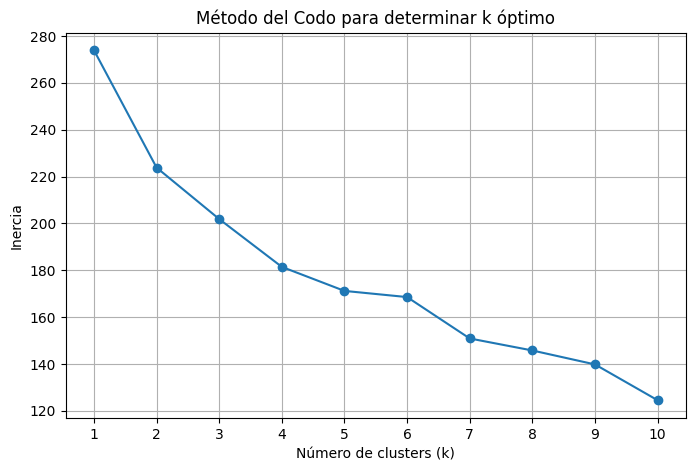

Número de observaciones por clúster:
  - Clúster 0: 352 observaciones
  - Clúster 1: 247 observaciones
  - Clúster 2: 6 observaciones
  - Clúster 3: 82 observaciones

Muestra de observaciones del clúster 0:


,Unnamed: 0,Nombre empresaAlfabeto latino,Inactive,Quoted,Branch,OwnData,País ISO Código,NACE Rev. 2 Código principal (4 digitos),Código de consolidación,Último año disponible,...,Sales_to_Fixed_Assets_2023,Sales_to_Fixed_Assets_2022,Sales_to_Fixed_Assets_2021,Sales_to_Fixed_Assets_2020,Fondo_Maniobra_2023,Fondo_Maniobra_2022,Fondo_Maniobra_2021,Fondo_Maniobra_2020,IsManufactured,Cluster
38,133,"HUALI INDUSTRIAL GROUP CO., LTD.",No,Sí,No,No,CN,1520,C1,2024,...,3.240921,3.824550,4.628638,4.805048,1.226019e+09,1.063294e+09,9.291623e+08,3.470013e+08,1,0
49,140,G III APPAREL GROUP LTD,No,Sí,No,No,US,1419,C1,2024,...,3.034975,3.044356,2.538875,1.881406,1.166690e+09,1.073431e+09,1.142052e+09,9.420380e+08,1,0
56,162,"FENG TAY ENTERPRISES CO., LTD.",No,Sí,No,No,TW,1520,C2,2024,...,3.262228,3.918069,3.704985,3.607560,2.742203e+08,3.563672e+08,2.337311e+08,1.719073e+08,1,0
57,165,"HANGZHOU FIRST APPLIED MATERIAL CO., LTD.",No,Sí,No,No,CN,1420,C1,2024,...,5.096932,5.241261,4.990110,4.173318,1.926050e+09,1.760599e+09,1.273595e+09,1.121557e+09,1,0
58,172,POU SHENG INTERNATIONAL (HOLDINGS) LIMITED,No,Sí,No,No,BM,4772,C1,2024,...,5.431406,4.655247,5.387552,4.744677,8.235595e+08,7.500772e+08,6.994259e+08,5.468197e+08,0,0



Muestra de observaciones del clúster 1:


,Unnamed: 0,Nombre empresaAlfabeto latino,Inactive,Quoted,Branch,OwnData,País ISO Código,NACE Rev. 2 Código principal (4 digitos),Código de consolidación,Último año disponible,...,Sales_to_Fixed_Assets_2023,Sales_to_Fixed_Assets_2022,Sales_to_Fixed_Assets_2021,Sales_to_Fixed_Assets_2020,Fondo_Maniobra_2023,Fondo_Maniobra_2022,Fondo_Maniobra_2021,Fondo_Maniobra_2020,IsManufactured,Cluster
6,13,FAST RETAILING CO LTD,No,Sí,No,No,JP,4771,C2,2024,...,2.432784,2.391476,3.578673,3.646680,9.998860e+09,8.998404e+09,7.900401e+09,6.961426e+09,0,1
7,14,HENNES & MAURITZ AB,No,Sí,No,No,SE,4771,C1,2024,...,2.443270,2.256367,2.378031,2.202246,1.155606e+09,1.025942e+09,1.633089e+09,8.345636e+08,0,1
8,15,ROSS STORES INC,No,Sí,No,No,US,4771,C1,2024,...,2.952337,2.871094,3.067293,2.079798,3.212342e+09,3.268473e+09,3.258247e+09,2.725458e+09,0,1
9,16,HERMES INTERNATIONAL,No,Sí,No,No,FR,1413,C1,2024,...,2.166236,2.059708,1.896612,1.656459,1.124505e+10,9.168288e+09,6.513900e+09,4.998146e+09,1,1
10,17,"THE GAP, INC.",No,Sí,No,No,US,4771,C1,2024,...,2.239284,2.306988,2.194576,1.778121,1.299000e+09,1.361000e+09,1.088000e+09,2.124000e+09,0,1



Muestra de observaciones del clúster 2:


,Unnamed: 0,Nombre empresaAlfabeto latino,Inactive,Quoted,Branch,OwnData,País ISO Código,NACE Rev. 2 Código principal (4 digitos),Código de consolidación,Último año disponible,...,Sales_to_Fixed_Assets_2023,Sales_to_Fixed_Assets_2022,Sales_to_Fixed_Assets_2021,Sales_to_Fixed_Assets_2020,Fondo_Maniobra_2023,Fondo_Maniobra_2022,Fondo_Maniobra_2021,Fondo_Maniobra_2020,IsManufactured,Cluster
0,1,LVMH MOET HENNESSY LOUIS VUITTON,No,Sí,No,No,FR,1413,C1,2024,...,0.916492,0.856587,0.769220,0.767703,1.097597e+10,8.514821e+09,6.557534e+09,1.522507e+10,1,2
1,2,"THE TJX COMPANIES, INC.",No,Sí,No,No,US,4771,C1,2024,...,3.173740,3.142012,3.193477,2.131916,2.213000e+09,2.151000e+09,2.790457e+09,4.935669e+09,0,2
2,3,NIKE INC,No,Sí,No,No,US,1520,C1,2024,...,4.154189,3.857780,3.890121,3.467736,1.594600e+10,1.748300e+10,1.661700e+10,1.227200e+10,1,2
3,4,INDUSTRIA DE DISENO TEXTIL S.A.,No,Sí,No,No,ES,1413,,2023,...,2.150069,2.121807,1.859601,1.477752,7.671509e+09,7.046215e+09,6.038374e+09,5.005608e+09,1,2
4,5,SALLUSTRO & CIA S.A,No,Sí,No,No,PY,1419,C2,2023,...,2.988434,2.952268,2.481998,1.781554,9.851475e+09,7.638804e+09,6.131139e+09,6.908799e+09,1,2



Muestra de observaciones del clúster 3:


,Unnamed: 0,Nombre empresaAlfabeto latino,Inactive,Quoted,Branch,OwnData,País ISO Código,NACE Rev. 2 Código principal (4 digitos),Código de consolidación,Último año disponible,...,Sales_to_Fixed_Assets_2023,Sales_to_Fixed_Assets_2022,Sales_to_Fixed_Assets_2021,Sales_to_Fixed_Assets_2020,Fondo_Maniobra_2023,Fondo_Maniobra_2022,Fondo_Maniobra_2021,Fondo_Maniobra_2020,IsManufactured,Cluster
13,34,LULULEMON ATHLETICA INC.,No,Sí,No,No,US,1413,C1,2024,...,3.173251,3.313682,2.687983,2.135968,2.429316e+09,1.667255e+09,1.209519e+09,1.241201e+09,1,3
22,60,THEME INTERNATIONAL HOLDINGS LIMITED,No,Sí,No,No,BM,1413,C1,2023,...,62.379341,48.272332,70.615234,574.789528,8.203268e+08,6.574762e+08,4.927688e+08,2.331753e+08,1,3
27,85,URBAN OUTFITTERS INC,No,Sí,No,No,US,4771,C1,2024,...,1.821765,1.961090,1.815439,1.485032,2.882980e+08,3.473450e+08,3.042740e+08,3.172000e+08,0,3
32,103,DECKERS OUTDOOR CORPORATION,No,Sí,No,No,US,1520,C1,2023,...,6.195330,5.615428,5.430477,4.924766,1.723490e+09,1.412873e+09,1.210444e+09,1.182431e+09,1,3
37,130,COLUMBIA SPORTSWEAR COMPANY,No,Sí,No,No,US,1413,C1,2024,...,3.772690,3.787594,3.280276,2.550134,1.418058e+09,1.398223e+09,1.433647e+09,1.302999e+09,1,3


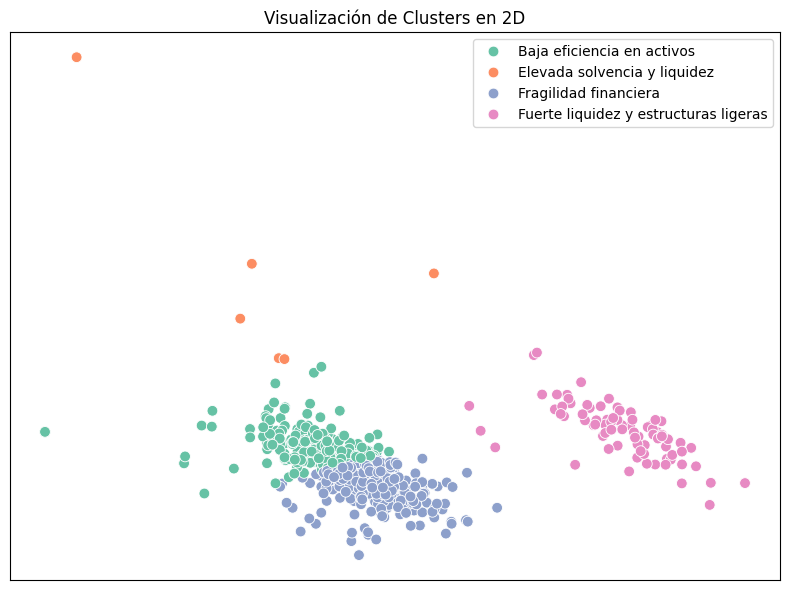

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)



Clúster 0 – Variables más distintivas:
  - Activos totales
USD 2021
  - Ingresos totales
USD 2021
  - Ventas Netas
USD 2021
  - Ventas brutas
USD 2021
  - Total pasivo y deuda
USD 2021

Clúster 1 – Variables más distintivas:
  - Capital_Intensity_Ratio_2021
  - Sales_to_Fixed_Assets_2021
  - EBIT_to_Sales_2021
  - Net_Profit_Margin_2021
  - Growth_Rate_Accounts_Receivable_2021

Clúster 2 – Variables más distintivas:
  - Capital_Intensity_Ratio_2021
  - Sales_to_Fixed_Assets_2021
  - EBIT_to_Sales_2021
  - Net_Profit_Margin_2021
  - Growth_Rate_Accounts_Receivable_2021

Clúster 3 – Variables más distintivas:
  - Net_Profit_Margin_2021
  - Net_Profit_to_Operating_Revenue_2021
  - Growth_Rate_Gross_Profit_2021
  - Capital_Intensity_Ratio_2021
  - Cash_Flow_from_Operations_to_Sales_2021
Archivo exportado correctamente a: /content/empresas_con_cluster.xlsx


In [ ]:
# Crear una instancia del analizador de clústeres con el Excel dado
analyzer = ClusteringAnalyzer(ruta_excel='/content/cluster.xlsx', year_column_filter="2021")

# Preprocesar los datos: filtrar columnas del año, limpiar valores anómalos y escalar los datos
analyzer.preprocess()

# Aplicar PCA para reducir a 2 dimensiones y poder visualizar en un plano
analyzer.aplicar_pca(n_componentes=2)

# Usar el método del codo para analizar cuántos clústeres podrían ser óptimos
analyzer.plot_elbow_method(max_k=10)

# Elegir 4 clústeres manualmente (por ejemplo, tras ver el gráfico del codo)
analyzer.n_clusters = 4

# Ejecutar KMeans con los datos proyectados en PCA
analyzer.run_kmeans(usar_pca=True)

# Mostrar cuántas empresas hay en cada clúster y ejemplos representativos
analyzer.mostrar_resultados_clustering()

# Etiquetas descriptivas para entender mejor qué representa cada clúster después de haberlos estudiado previamente
nombre_clusters = {
    0: "Fragilidad financiera",
    1: "Baja eficiencia en activos",
    2: "Elevada solvencia y liquidez",
    3: "Fuerte liquidez y estructuras ligeras"
}

# Dibujar los puntos (empresas) en el plano 2D con colores y etiquetas por clúster
analyzer.plot_clusters(nombres_cluster=nombre_clusters)

# Identificar las variables que mejor definen a cada clúster (top 5 por desviación respecto a la media global)
variables_destacadas = analyzer.variables_mas_representativas(top_n=5)

# Imprimir por pantalla las variables clave de cada clúster
for cluster, variables in variables_destacadas.items():
    print(f"\nClúster {cluster} – Variables más distintivas:")
    for var in variables:
        print(f"  - {var}")

# Exportar todo el DataFrame (original + columna Cluster) a un archivo Excel
analyzer.exportar_resultado_a_excel("/content/empresas_con_cluster.xlsx")
